Галлямов Артур, КЭ-403, лабораторная работа №1

Постановка задания:
1. Разработайте программу, которая выполняет поиск частых наборов объектов в заданном наборе данных с помощью алгоритма Apriori (или одной из его модификаций). Список результирующих наборов должен содержать как наборы, так и значение поддержки для каждого набора. Параметрами программы являются набор, порог поддержки и способ упорядочивания результирующего списка наборов (по убыванию значения поддержки или лексикографическое).
2. Проведите эксперименты на наборе данных baskets.csv (сведения о покупках в супермаркете). В экспериментах варьируйте пороговое значение поддержки (например: 1%, 3%, 5%, 10%, 15%).
3. Выполните визуализацию результатов экспериментов в виде следующих диаграмм:
сравнение быстродействия на фиксированном наборе данных при изменяемом пороге поддержки;
количество частых наборов объектов различной длины на фиксированном наборе данных при изменяемом пороге поддержки.
4. Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  
формулировка задания; 
гиперссылка на каталог репозитория с исходными текстами, наборами данных и др. сопутствующими материалами; 
рисунки с результатами визуализации; 
пояснения, раскрывающие смысл полученных результатов.

[Гиперссылка на репозиторий](url_here)

In [68]:
import time
import pandas as pd
import chardet
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import matplotlib.pyplot as plt

In [69]:
with open('baskets.csv', 'rb') as f:
    result = chardet.detect(f.read())

df = pd.read_csv('baskets.csv', encoding=result['encoding'], header=None)
df = df.values.tolist()
df = [[x for x in l if str(x) != 'nan'] for l in df]

te = TransactionEncoder()
te_ary = te.fit(df).transform(df)
df = pd.DataFrame(te_ary, columns=te.columns_)

apr_df = apriori(df, 0.01, use_colnames=True)
apr_df['length'] = apr_df['itemsets'].apply(lambda x: len(x))
apr_df

,support,itemsets,length
0,0.033329,(авокадо),1
1,0.013198,(баклажаны),1
2,0.011465,(батат),1
3,0.016531,(белое вино),1
4,0.013598,(белый сыр),1
...,...,...,...
256,0.011199,"(шоколад, молоко, макароны)",3
257,0.010932,"(шоколад, макароны, яйца)",3
258,0.013998,"(шоколад, молоко, минеральная вода)",3
259,0.013065,"(молоко, минеральная вода, яйца)",3


<function matplotlib.pyplot.show(close=None, block=None)>

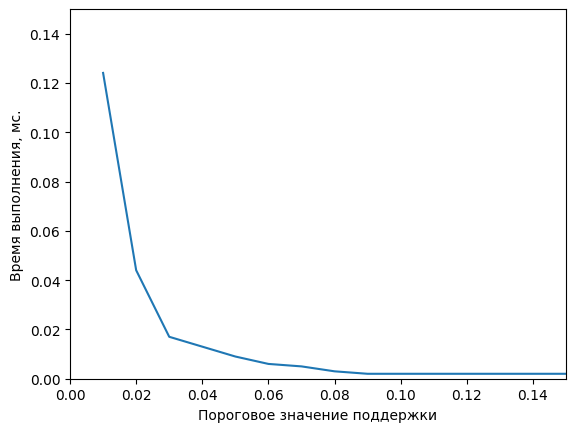

In [70]:
support = 0.01
support_list = []
execution_time_list = []

while support <= 0.15:
    start_time = time.time()
    apr_df = apriori(df, support, use_colnames=True)
    execution_time_list.append(time.time() - start_time)
    support_list.append(support)
    support += 0.01

plt.plot(support_list, execution_time_list)
plt.axis((0.0, 0.15, 0.0, 0.15))
plt.xlabel('Пороговое значение поддержки')
plt.ylabel('Время выполнения, мс.')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

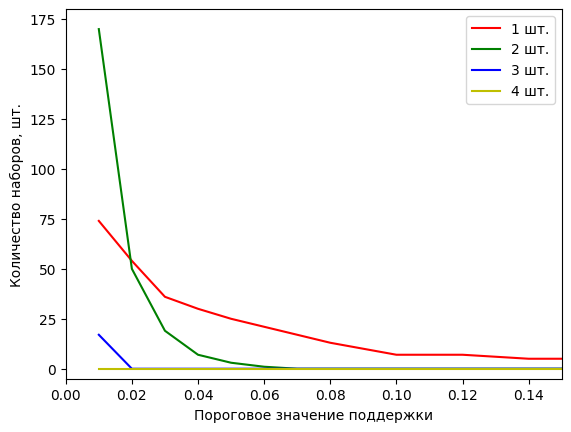

In [71]:
amount_1 = []
amount_2 = []
amount_3 = []
amount_4 = []
support = 0.01

while support <= 0.15:
    apr_df = apriori(df, support, use_colnames=True)
    apr_df['length'] = apr_df['itemsets'].apply(lambda x: len(x))

    amount_1.append(apr_df['length'].value_counts().get(1, 0))
    amount_2.append(apr_df['length'].value_counts().get(2, 0))
    amount_3.append(apr_df['length'].value_counts().get(3, 0))
    amount_4.append(apr_df['length'].value_counts().get(4, 0))

    support += 0.01

plt.plot(support_list, amount_1, 'r-', support_list, amount_2, 'g-', support_list, amount_3, 'b-', support_list, amount_4, 'y-')
plt.axis((0.0, 0.15, -5, 180))
plt.xlabel('Пороговое значение поддержки')
plt.ylabel('Количество наборов, шт.')
plt.legend(('1 шт.', '2 шт.', '3 шт.', '4 шт.'))
plt.show